# Segmenting and Clustering Neighborhoods in Toronto

Explore, segment, and cluster the neighborhoods in the city of Toronto.

This Notebook contains all the parts of the assignment. I've labeled them with the headings: Part 1, Part 2, Part 3

## Part 1 

### Data Cleaning and Preprocessing
In this section we are going to clean and prepare the data using the following guidelines

1. Rename the Postcode column to PostalCode
2. Remove all rows with unassigned Boroughs
3. Aggregate data so that Neightborhoods sharing more than one postal code are grouped in a comma separated value format
4. Upate the value of unassigned Neighbourhoods with the value of the Borough

In [82]:
import pandas as pd
import numpy as np


Read in the data from Wikipedia using the pd.read_html helper from the Pandas library



In [83]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]

In [84]:
#1. Rename column
df.rename(columns={'Postcode': 'PostalCode'}, inplace=True)

In [85]:
#2. Filter out unassigned boroughs
filtered_data = df[df['Borough' ] != 'Not assigned'].reset_index(drop=True)
   
#3. Group by postal code to show neighborhoods sharing same postal code
groups = filtered_data.groupby(['PostalCode', 'Borough'], as_index=False).agg(lambda x: ','.join(x))

#4. Update any neighborhoods that are unassigned and give them the name of the borough
groups.loc[groups['Neighbourhood'] == 'Not assigned', ['Neighbourhood']] = groups['Borough']
# groups.loc[matching row, [columns] = values

#groups

Show the shape of the cleaned data set

In [86]:
groups.shape

(103, 3)

### Part 2

Import the geo_data containing the Latitude and Longitute for each Neighbourhood and Borough and merge it into the original dataframe


In [87]:
geo_data = pd.read_csv("https://cocl.us/Geospatial_data")

First rename the column so we can use it for the key column in our merge.

In [88]:

# need to clean up column name so I can merge on the index
geo_data.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)


Perform an inner join merge using the PostalCode column as the key

In [89]:
# perform an inner join merge using the PostalCode as the key
groups = groups.merge(geo_data, on='PostalCode', how='inner')

groups

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


In [90]:
groups.shape

(103, 5)

In [91]:
groups

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


### Part 3

Data Analysis - Cluster and segment the neighborhoods


Get a subset of the dataframe that includes all Boroughs with the word Toronto in it

In [104]:
# Get a dataframe with only Boroughs containing 'Toronto' 
neighborhoods = groups[groups['Borough'].str.contains('Toronto')].reset_index()

neighborhoods


,index,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,37,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,43,M4M,East Toronto,Studio District,43.659526,-79.340923
4,44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,47,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,48,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160
9,49,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049


In [105]:
# clean up dataframe
neighborhoods.drop(['index', 'PostalCode'], inplace=True, axis=1)
neighborhoods


,Borough,Neighbourhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,Central Toronto,Lawrence Park,43.728020,-79.388790
5,Central Toronto,Davisville North,43.712751,-79.390197
6,Central Toronto,North Toronto West,43.715383,-79.405678
7,Central Toronto,Davisville,43.704324,-79.388790
8,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160
9,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049


In [112]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        toronto_df.shape[0]
    )
)

The dataframe has 4 boroughs and 39 neighborhoods.


Install geopy and Folium, so we can visualize the cluster of Neighborhoods on a map

In [ ]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

In [107]:
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [108]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


In [114]:
# create map of Toronto using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

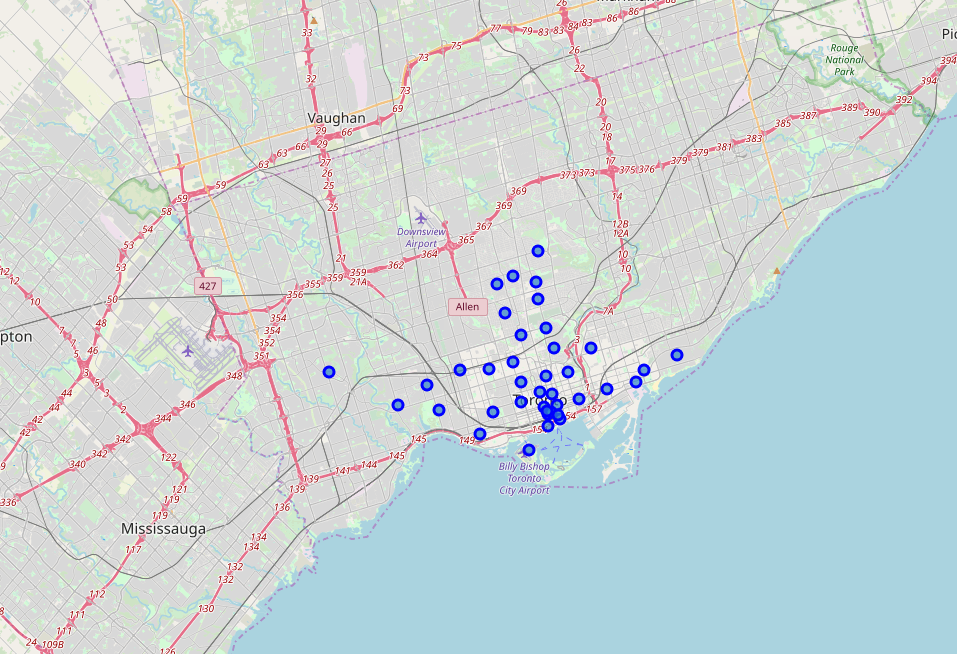

Select one Borough and put the clusters on a map

In [115]:
east_toronto = neighborhoods[neighborhoods['Borough'] == 'East Toronto'].reset_index(drop=True)
east_toronto.head()

,Borough,Neighbourhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558


In [116]:
address = 'East Toronto, Canada'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of East Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of East Toronto are 43.626243, -79.396962.


In [119]:
# create map of Manhattan using latitude and longitude values
map_east_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(east_toronto['Latitude'], east_toronto['Longitude'], east_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_east_toronto)  
    
map_east_toronto

In [126]:
# The code was removed by Watson Studio for sharing.